# 3. software autofocus

In [1]:
import os
import time
from useq import MDAEvent, MDASequence, Position
from pymmcore_plus.mda import mda_listeners_connected
from pymmcore_plus.mda.handlers import ImageSequenceWriter
import matplotlib.pyplot as plt
import matplotlib.image as img
import cv2
import numpy as np
from scipy.optimize import curve_fit
import glob
import pandas as pd
import m2stitch
from os import path

# set micro manager directory
mm_dir = 'D:\ProgramFiles\Micro-Manager-2.0'

# load micro manager system configuration
from pymmcore_plus import CMMCorePlus, Device, DeviceAdapter, ConfigGroup
core = CMMCorePlus()
#core_plus.setDeviceAdapterSearchPaths([mm_dir])
core.loadSystemConfiguration(os.path.join(mm_dir, 'MMConfig_Edge42_SOLA_ASIStage_PixelSize.cfg'))

In [2]:
# set field of view size
f = 1192.8

In [3]:
# acquire z-stack

z = -900
range = 10
step_size = 1

writer = ImageSequenceWriter(r'C:\Users\Admin\Desktop\focus', extension=".png", overwrite=True)

sequence = MDASequence(
    axis_order = "tpgcz",
    stage_positions = [(1200, 1214, z)],
    channels = [{'group': 'LED_light', 'config': 'on'}],
    z_plan = {'above': range, 'below': range, 'step': step_size}
)

with mda_listeners_connected(writer):
    core.mda.run(sequence)
    
core.snapImage()
im = core.getImage()

core.setConfig('LED_light', 'off')

2024-08-14 18:02:35,520 - pymmcore-plus - INFO - (_runner.py:321) MDA Started: stage_positions=(Position(x=1200.0, y=1214.0, z=-900.0, name=None, sequence=None),) channels=(Channel(config='on', group='LED_light', exposure=None, do_stack=True, z_offset=0.0, acquire_every=1, camera=None),) z_plan=ZAboveBelow(go_up=True, above=10.0, below=10.0, step=1.0)
2024-08-14 18:02:35,521 - pymmcore-plus - INFO - (_runner.py:283) index=mappingproxy({'p': 0, 'c': 0, 'z': 0}) channel=Channel(config='on', group='LED_light') x_pos=1200.0 y_pos=1214.0 z_pos=-910.0
2024-08-14 18:02:36,118 - pymmcore-plus - INFO - (_runner.py:283) index=mappingproxy({'p': 0, 'c': 0, 'z': 1}) channel=Channel(config='on', group='LED_light') x_pos=1200.0 y_pos=1214.0 z_pos=-909.0
2024-08-14 18:02:36,702 - pymmcore-plus - INFO - (_runner.py:283) index=mappingproxy({'p': 0, 'c': 0, 'z': 2}) channel=Channel(config='on', group='LED_light') x_pos=1200.0 y_pos=1214.0 z_pos=-908.0
2024-08-14 18:02:37,281 - pymmcore-plus - INFO - (_r

In [4]:
focus_images = glob.glob(r'C:\Users\Admin\Desktop\focus\*.png')
focus_images

['C:\\Users\\Admin\\Desktop\\focus\\00000_p000_c00_z000.png',
 'C:\\Users\\Admin\\Desktop\\focus\\00001_p000_c00_z001.png',
 'C:\\Users\\Admin\\Desktop\\focus\\00002_p000_c00_z002.png',
 'C:\\Users\\Admin\\Desktop\\focus\\00003_p000_c00_z003.png',
 'C:\\Users\\Admin\\Desktop\\focus\\00004_p000_c00_z004.png',
 'C:\\Users\\Admin\\Desktop\\focus\\00005_p000_c00_z005.png',
 'C:\\Users\\Admin\\Desktop\\focus\\00006_p000_c00_z006.png',
 'C:\\Users\\Admin\\Desktop\\focus\\00007_p000_c00_z007.png',
 'C:\\Users\\Admin\\Desktop\\focus\\00008_p000_c00_z008.png',
 'C:\\Users\\Admin\\Desktop\\focus\\00009_p000_c00_z009.png',
 'C:\\Users\\Admin\\Desktop\\focus\\00010_p000_c00_z010.png',
 'C:\\Users\\Admin\\Desktop\\focus\\00011_p000_c00_z011.png',
 'C:\\Users\\Admin\\Desktop\\focus\\00012_p000_c00_z012.png',
 'C:\\Users\\Admin\\Desktop\\focus\\00013_p000_c00_z013.png',
 'C:\\Users\\Admin\\Desktop\\focus\\00014_p000_c00_z014.png',
 'C:\\Users\\Admin\\Desktop\\focus\\00015_p000_c00_z015.png',
 'C:\\Us

In [5]:
focus_scores = []
for f in focus_images:
    im = cv2.imread(rf'{f}')
    im_filtered = cv2.medianBlur(im, ksize=3)
    laplacian = cv2.Laplacian(im_filtered, ddepth=cv2.CV_64F, ksize=3)
    focus_score = laplacian.var()
    focus_scores.append(focus_score)

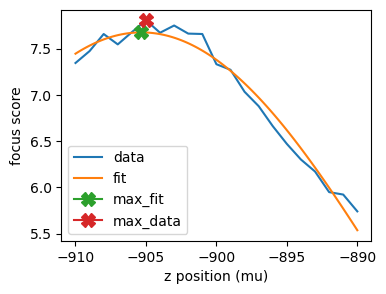

-905.3535353535353 -905.0


In [6]:
# define x and y for fitting
y = focus_scores
x = np.linspace(z-range, z+range, len(y))

# define gauss fit function
mean = sum(x * y) / sum(y)
sigma = np.sqrt(sum(y * (x - mean)**2) / sum(y))
def gauss(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

popt, pcov = curve_fit(gauss, x, y, p0=[np.max(y), mean, sigma])

# calculate maximum focus score of fit function
x_fine = np.linspace(z-range, z+range, 100)
y_max = np.max(gauss(x_fine,*popt))
pos = np.where(y_max == gauss(x_fine,*popt))
x_max = x_fine[pos]
y_max_data = np.max(focus_scores)
x_max_data = x[np.where(focus_scores == y_max_data)]

# plot focus scores, fit function and maximum
fig, ax = plt.subplots(figsize=(4, 3))
plt.plot(x, y, label='data')
plt.plot(x_fine, gauss(x_fine, *popt), label='fit')
plt.plot(x_max, y_max, marker='X', label='max_fit', ms=10)
plt.plot(x_max_data, y_max_data, marker='X', label='max_data', ms=10)
plt.xlabel('z position (mu)')
plt.ylabel('focus score')
plt.legend()
plt.show()

# set optimal z position 
core.setPosition(float(x_max[0]))

print(float(x_max[0]), float(x_max_data[0]))

Text(0.5, 1.0, 'data, value=-905.0')

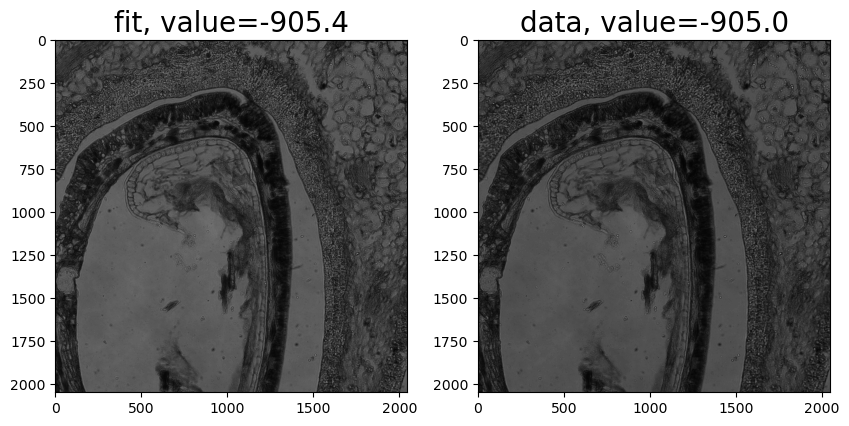

In [7]:
# compare maximum focus score of data vs. gaussian fit function
core.setConfig('LED_light', 'on')
time.sleep(1)

core.setPosition(float(x_max[0]))
core.snapImage()
im_fit = core.getImage()

core.setPosition(float(x_max_data[0]))
core.snapImage()
im_data = core.getImage()

time.sleep(1)
core.setConfig('LED_light', 'off')

fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
ax[0].imshow(im_fit, cmap='gray')
ax[0].set_title(f'fit, value={np.round(x_max[0], 1)}', fontsize=20)
ax[1].imshow(im_data, cmap='gray')
ax[1].set_title(f'data, value={np.round(x_max_data[0], 1)}', fontsize=20)

In [8]:
# remove focus images 
for file in focus_images:
    os.remove(file)